# Question 4

Is there some relation between the commenting activity and the decision to stop “depending on” / “contributing to” a package? People may get dissatisfied with some package. In that case, they might either suddenly discontinue using/contributing to that package, or there may be “early signs” of this dissatisfaction in terms of their commenting activity.

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:6]

## Load comments

In [2]:
all_comments = read_comments();
all_comments = all_comments[lambda x: x['author_assoc'] != 'NONE'][lambda x: x['author_assoc'] != 'MEMBER']
all_comments['created_at'] = pandas.to_datetime(all_comments['created_at'])

In [3]:
all_comments.head()

,Name,user_login,author_assoc,created_at,type
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt
5,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 07:43:55,cmt


### Load package dependencies

In [4]:
df_pckdpnd = pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',parse_dates=['fst_release','lst_release','first_time','last_time'])
df_pckdpnd = df_pckdpnd.drop(df_pckdpnd.columns[0],axis=1)
df_pckdpnd.shape

(48597, 10)

In [5]:
cntb_cmnts = pandas.DataFrame()
new_data = pandas.DataFrame()
def check_comments(row):
    global cntb_cmnts
    global new_data
    contributors = all_comments[lambda x: x['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments[lambda x: x['Name'] == row['target']][all_comments['user_login'].isin(contributors)][all_comments['created_at'] < row['last_time']]
    cntb_cmnts = cntb_cmnts.append(cont_depends.reset_index(),ignore_index=True)
    counter = collections.Counter(cont_depends.type.values)
    new_data = new_data.append({
                        "Name": row['package'],
                        "target": row['target'],
                        "contributor_commented_before_use": cont_depends.user_login.unique() if len(cont_depends)>0 else np.nan,
                        "Number_of_contributors": len(cont_depends.user_login.unique()),
                        "pulls": counter['pul'] if 'pul' in counter else 0,
                        "issues": counter['isu'] if 'isu' in counter else 0,
                        "commit": counter['cmt'] if 'cmt' in counter else 0,
                        "pullrq": counter['prq'] if 'prq' in counter else 0,
                        "comments_id": cont_depends.index.unique() if len(cont_depends)>0 else np.nan},ignore_index=True)
    return 1;

In [6]:
df_pckdpnd['done'] = df_pckdpnd.apply(lambda row: check_comments(row),axis=1)

In [7]:
df_data = df_pckdpnd.drop('done',axis=1).merge(new_data,left_on=['package','target'],right_on=['Name','target']).drop('Name',axis=1)

In [8]:
df_data.head()

,package,version,target,fst_release,lst_release,first_time,last_time,elimination,period,removed,Number_of_contributors,comments_id,commit,contributor_commented_before_use,issues,pullrq,pulls
0,BrewStillery,1.0.0,gtk,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2018-03-05 00:56:07,0.000000,150.155174,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
1,BrewStillery,1.0.0,regex,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2017-10-06 15:27:04,149.395174,0.760000,1,0.0,NaN,0.0,NaN,0.0,0.0,0.0
2,BrewStillery,5.0.0,gio,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
3,BrewStillery,5.0.0,gdk,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
4,ConExpression,0.1.0,rand,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,0.000000,0.000000,0,0.0,NaN,0.0,NaN,0.0,0.0,0.0


In [9]:
cntb_cmnts = cntb_cmnts.sort_values(['Name','user_login','created_at']).drop_duplicates(subset=['Name','user_login'],keep='first')
def find_depend_data(index):
    index_of_cmnt = -1
    for id, row in df_data.dropna().iterrows():
        if index in row['comments_id']:
            index_of_cmnt = id
            break
    return df_data.loc[id]['last_time'] if df_data.loc[id]['last_time'] < df_data.loc[id]['lst_release'] else np.nan
    
cntb_cmnts['time_of_remove'] = cntb_cmnts.apply(lambda r: find_depend_data(r['index']),axis=1)

In [10]:
cntb_cmnts['time_diff'] = cntb_cmnts.dropna().apply(lambda r: (r['time_of_remove']- r['created_at']).total_seconds()/3600/24/7,axis=1)
cntb_cmnts['year'] = cntb_cmnts.apply(lambda r: r['created_at'].year,axis=1)

In [12]:
cntb_cmnts = cntb_cmnts.dropna()
#df_sorted_filtered = cntb_cmnts.sort_values(['user_login','Name']).drop_duplicates(subset=['user_login','Name'],keep='last')

[Text(0.5, 0, 'Time difference between start commenting on a package and stop depending on a package')]

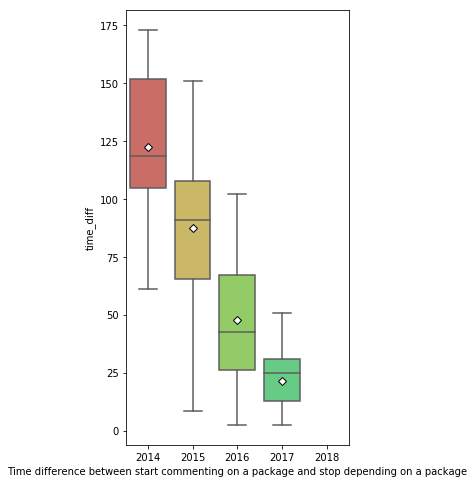

In [13]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='year', 
    y='time_diff', 
    data=(
        cntb_cmnts[['year','time_diff']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time difference between start commenting on a package and stop depending on a package', 
)

[Text(0, 0.5, 'proportion of comment types'), Text(0.5, 0, '')]

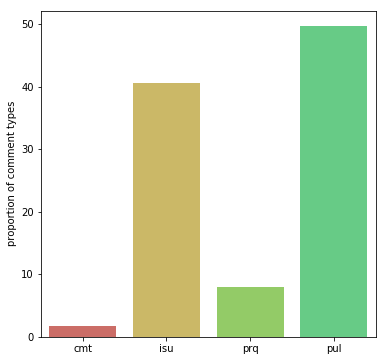

In [14]:
plt.rcParams["figure.figsize"] = (6,6)

df_bar = (cntb_cmnts[['Name','time_of_remove','type']]
        .assign(proportion = 1)
        .groupby(['type']).sum().reset_index()
        )
df_bar['proportion'] = df_bar.apply(lambda d: d['proportion']/df_bar['proportion'].sum()*100, axis=1)

ax = seaborn.barplot(
    x='type',
    y='proportion',
    data=df_bar,
    palette=palet 
)

ax.set(
    xlabel='',
    ylabel='proportion of comment types'
)

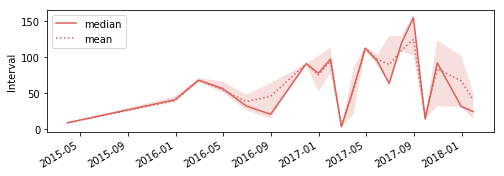

In [15]:
plt.rcParams["figure.figsize"] = (8,2.5)
df_tmp = (
    cntb_cmnts
    [['type','time_of_remove','time_diff']]
    .groupby(pandas.Grouper(key='time_of_remove', freq='1M'))
    ['time_diff']
    .describe()
    [['mean','25%','50%','75%']]
    .dropna()
)
fig, ax = plt.subplots()
df_tmp['50%'].rename('median').plot(color=palet, ax=ax)
df_tmp['mean'].plot(color=palet, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=palet[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Interval',
    label = 'Interval of start commenting on a package and elimination'
)
ax.legend(loc='upper left')

In [16]:
plt.rcParams["figure.figsize"] = (8,2.5)
df_tmp = (
    df_data
    [['last_time','removed']]
    .groupby(pandas.Grouper(key='last_time', freq='1M'))
)
df_tmp

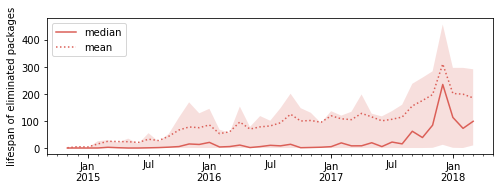

In [17]:
df_tmp = (
    df_data
    [['last_time','period']]
    .groupby(pandas.Grouper(key='last_time', freq='1M'))
    ['period']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
)
fig, ax = plt.subplots()
df_tmp['50%'].rename('median').plot(color=palet, ax=ax)
df_tmp['mean'].plot(color=palet, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=palet[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='lifespan of eliminated packages'
)
ax.legend(loc='upper left')

In [18]:
def com_before_elimination(x):
    return 1 if x['Number_of_contributors']>0 and x['last_time']<x['lst_release'] else 0

df_data['cntrcmnted'] = df_data.apply(lambda x: com_before_elimination(x),axis=1)

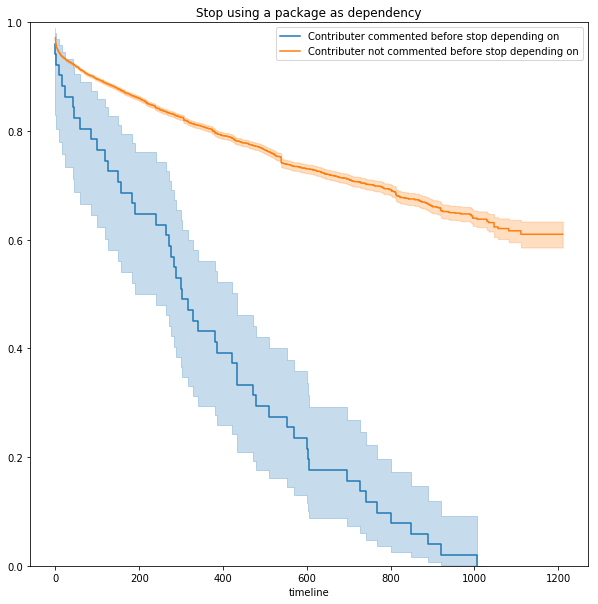

In [23]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.rcParams["figure.figsize"] = (10,10)
ax = plt.subplot(111)

cmnt = (df_data[lambda x: x["cntrcmnted"] == 1])
ncmnt = (df_data[lambda x: x["cntrcmnted"] == 0])
kmf.fit(cmnt['period'], event_observed=cmnt['removed'], label="Contributer commented before stop depending on")
kmf.plot(ax=ax)
kmf.fit(ncmnt['period'], event_observed=ncmnt['removed'], label="Contributer not commented before stop depending on")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Stop using a package as dependency");

          NA_estimate
timeline             
0.000000     0.028871
0.000162     0.028955
0.000243     0.028955
0.000347     0.028955
0.000486     0.028955


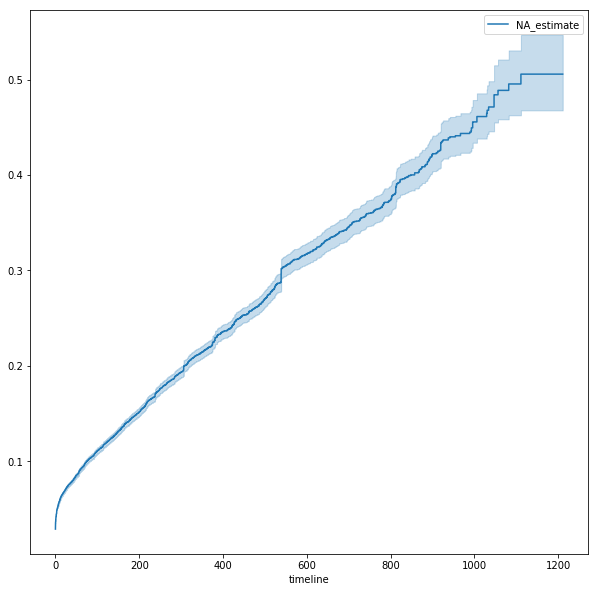

In [24]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(df_data['period'], event_observed=df_data['removed'])
print(naf.cumulative_hazard_.head())
naf.plot()

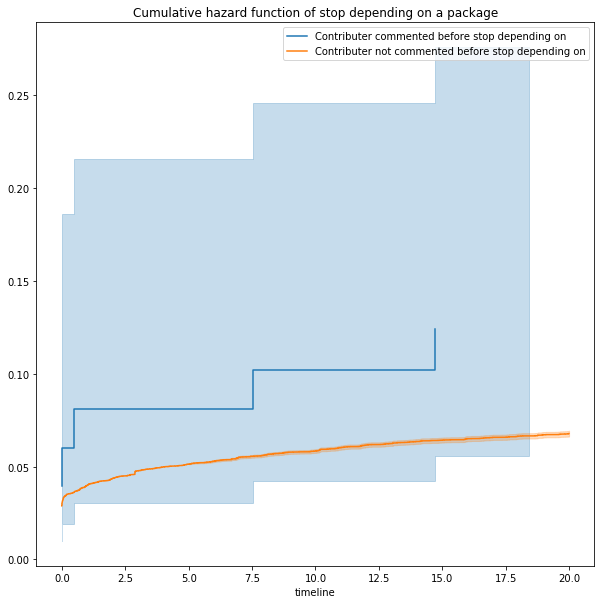

In [25]:
naf.fit(cmnt['period'], event_observed=cmnt['removed'], label="Contributer commented before stop depending on")
ax = naf.plot(loc=slice(0, 20))
naf.fit(ncmnt['period'], event_observed=ncmnt['removed'], label="Contributer not commented before stop depending on")
naf.plot(ax=ax, loc=slice(0, 20))
plt.title("Cumulative hazard function of stop depending on a package");

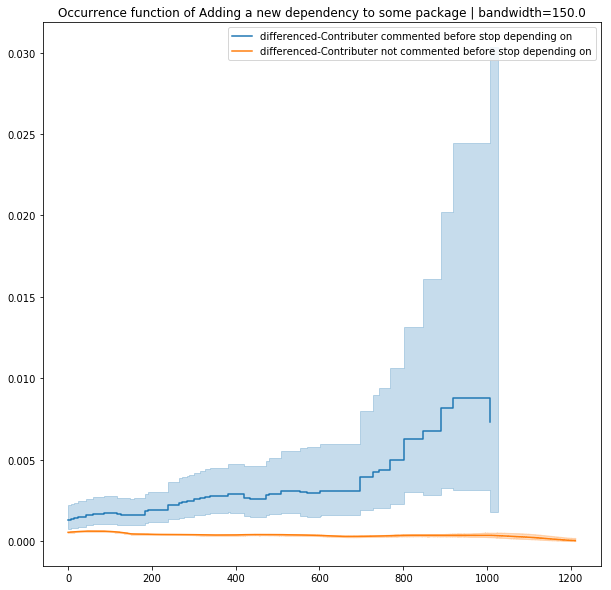

In [26]:
b = 150
naf.fit(cmnt['period'], event_observed=cmnt['removed'], label="Contributer commented before stop depending on")
ax = naf.plot_hazard(bandwidth=b)
naf.fit(ncmnt['period'], event_observed=ncmnt['removed'], label="Contributer not commented before stop depending on")
naf.plot_hazard(ax=ax, bandwidth=b)
plt.title("Occurrence function of Adding a new dependency to some package | bandwidth=%.1f"%b);